In [39]:
import pandas as pd
import numpy as np
import shap
import matplotlib
import sklearn
import xgboost
import sys

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("shap:", shap.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)


Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.1.2
shap: 0.49.1
matplotlib: 3.10.7
scikit-learn: 1.7.2
xgboost: 3.1.2



📌 FINAL PCA-SELECTED NUMERIC FEATURES (Improved, Leak-Free):
['rush_hour', 'traffic_ordinal', 'peak_traffic', 'multi_peak', 'multiple_deliveries', 'distance_traffic', 'hour_of_order', 'delay_weekend', 'distance_km', 'delivery_person_ratings', 'dist_order_hour', 'order_dayofweek']

🔍 Running XGBoost RandomizedSearchCV...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=400, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=400, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=400, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=400, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.7, xgb__learning_ra

PermutationExplainer explainer: 1001it [00:19, 24.56it/s]                                                              
C:\Users\User\AppData\Local\Temp\ipykernel_20388\1588586932.py:363: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


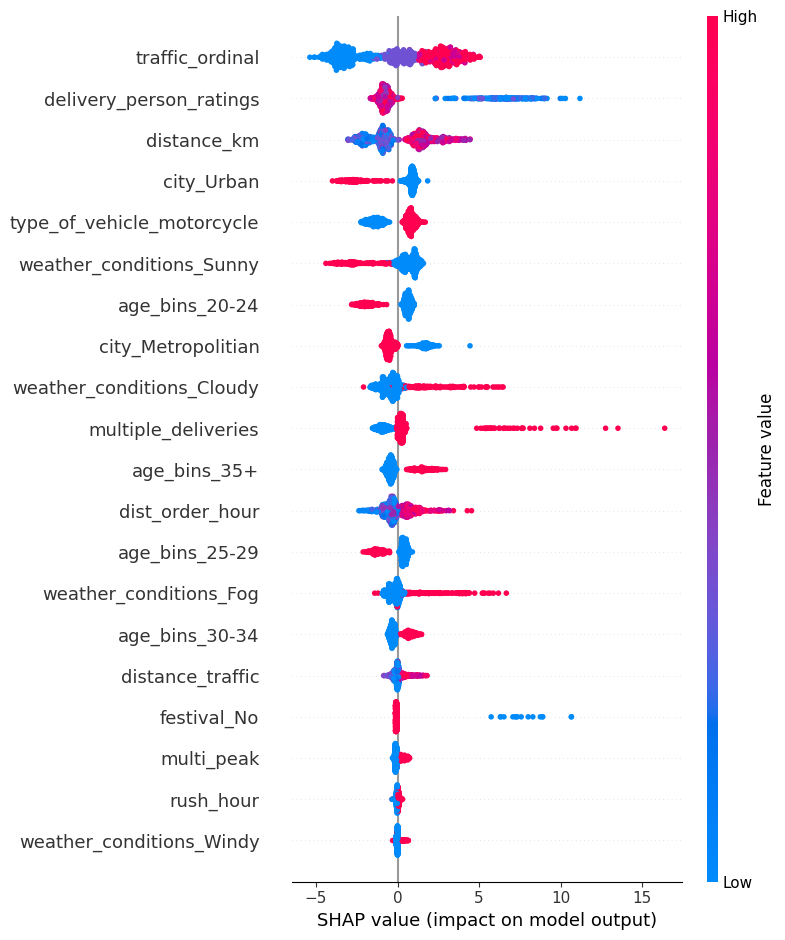

In [25]:
# ============================================================
# 1. IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# ============================================================
# 2. LOAD + BASIC CLEANING
# ============================================================
df = pd.read_csv("Dataset.csv")

df.columns = [col.lower() for col in df.columns]
df.rename(columns={"time_taken (min)": "time_taken_min"}, inplace=True)

df["order_date"] = pd.to_datetime(df["order_date"], format="%d-%m-%Y", errors="coerce")
df = df.dropna(subset=["order_date"]).reset_index(drop=True)

# Fix negative GPS values
gps_cols = [
    "restaurant_latitude","restaurant_longitude",
    "delivery_location_latitude","delivery_location_longitude"
]
df[gps_cols] = df[gps_cols].abs()

# ============================================================
# 3. FEATURE ENGINEERING
# ============================================================

# Month and age bins
df["order_month"] = df["order_date"].dt.strftime('%b')

bins = [20, 25, 30, 35, 50]
labels = ["20-24", "25-29", "30-34", "35+"]
df["age_bins"] = pd.cut(df["delivery_person_age"], bins=bins, labels=labels)

# Parse order time
df["time_orderd"] = pd.to_datetime(df["time_orderd"], format="%H:%M", errors="coerce")

def is_peak_hour(row):
    hr = pd.to_datetime(row["time_orderd"]).hour
    return 1 if (11 <= hr < 14) or (17 <= hr < 21) else 0

df["peak_hours"] = df.apply(is_peak_hour, axis=1)

# -------- Haversine Distance --------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = (np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*(np.sin(dlon/2)**2))
    return 2 * R * np.arcsin(np.sqrt(a))

df["distance_km"] = haversine(
    df["restaurant_latitude"], df["restaurant_longitude"],
    df["delivery_location_latitude"], df["delivery_location_longitude"]
)

# -------- Combine date & order time (for time features only) --------
df["time_orderd"] = pd.to_datetime(df["time_orderd"], format="%H:%M", errors="coerce").dt.time

df["order_datetime"] = pd.to_datetime(
    df["order_date"].dt.strftime('%Y-%m-%d') + " " + df["time_orderd"].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)
df = df.dropna(subset=["order_datetime"]).reset_index(drop=True)

# Base time features
df["order_dayofweek"] = df["order_date"].dt.dayofweek
df["is_weekend"] = df["order_dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

df["hour_of_order"] = df["order_datetime"].dt.hour
df["day_of_month"] = df["order_datetime"].dt.day
df["week_of_year"] = df["order_datetime"].dt.isocalendar().week.astype(int)
df["order_hour"] = df["hour_of_order"]

# Distance × traffic interactions
df["distance_traffic"] = df["distance_km"] * df["peak_hours"]
df["delay_weekend"] = df["peak_hours"] * df["is_weekend"]
df["rating_vehicle"] = df["delivery_person_ratings"] * df["vehicle_condition"]

# Driver score
df["driver_score"] = df["delivery_person_ratings"] * (df["vehicle_condition"] / 10.0)

# Part of day
def part_of_day(h):
    if 5 <= h < 11:
        return "morning"
    elif 11 <= h < 15:
        return "lunch"
    elif 15 <= h < 18:
        return "afternoon"
    elif 18 <= h < 22:
        return "evening"
    else:
        return "night"

df["part_of_day"] = df["hour_of_order"].apply(part_of_day)

# Rush hour flag (slightly wider than peak_hours)
def is_rush_hour(h):
    return 1 if (11 <= h < 15) or (18 <= h < 22) else 0

df["rush_hour"] = df["hour_of_order"].apply(is_rush_hour)

# Traffic ordinal (severity encoding)
traffic_map = {
    "low": 1,
    "medium": 2,
    "high": 3,
    "jam": 4
}
df["traffic_ordinal"] = (
    df["road_traffic_density"]
      .str.lower()
      .map(traffic_map)
)

# Distance bins (for non-linear pattern)
df["distance_bin"] = pd.qcut(df["distance_km"], 5, labels=False, duplicates="drop")

# Interaction features
df["dist_order_hour"] = df["distance_km"] * df["order_hour"]
df["peak_traffic"] = df["peak_hours"] * df["traffic_ordinal"].fillna(0)
df["multi_peak"] = df["multiple_deliveries"] * df["peak_hours"]

# ============================================================
# 4. ZONE CLUSTERING (KMeans on GPS)
# ============================================================
coords_rest = df[["restaurant_latitude","restaurant_longitude"]]
coords_cust = df[["delivery_location_latitude","delivery_location_longitude"]]

k = 12  # number of zones

kmeans_rest = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_cust = KMeans(n_clusters=k, random_state=42, n_init=10)

df["restaurant_zone"] = kmeans_rest.fit_predict(coords_rest).astype(str)
df["customer_zone"] = kmeans_cust.fit_predict(coords_cust).astype(str)

# ============================================================
# 5. FINAL FEATURE LISTS (LEAK-FREE, ENGINEERED)
# ============================================================
numeric_features = [
    "distance_km",
    "distance_traffic",
    "driver_score",
    "delivery_person_age",
    "delivery_person_ratings",
    "vehicle_condition",
    "multiple_deliveries",
    "order_dayofweek",
    "week_of_year",
    "day_of_month",
    "hour_of_order",
    "rush_hour",
    "traffic_ordinal",
    "rating_vehicle",
    "delay_weekend",
    "dist_order_hour",
    "peak_traffic",
    "multi_peak",
]

categorical_features = [
    "weather_conditions",
    "road_traffic_density",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city",
    "order_month",
    "age_bins",
    "part_of_day",
    "restaurant_zone",
    "customer_zone",
    "distance_bin",
]

# ============================================================
# 6. PCA-BASED NUMERIC SELECTION (LEAK-FREE)
# ============================================================
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

scaler_for_pca = StandardScaler()
scaled = scaler_for_pca.fit_transform(df[numeric_features])

pca = PCA(n_components=len(numeric_features))
pca.fit(scaled)

loadings = pd.DataFrame(
    np.abs(pca.components_.T) * pca.explained_variance_ratio_,
    index=numeric_features
)

importance = loadings.sum(axis=1).sort_values(ascending=False)
selected_num_features = importance.head(12).index.tolist()

print("\n📌 FINAL PCA-SELECTED NUMERIC FEATURES (Improved, Leak-Free):")
print(selected_num_features)

# ============================================================
# 7. TRAIN / TEST SPLIT
# ============================================================
X = df[selected_num_features + categorical_features]
y = df["time_taken_min"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 8. PREPROCESSOR
# ============================================================
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, selected_num_features),
    ("cat", categorical_transformer, categorical_features)
])

# ============================================================
# 9. MODELS (RF + XGBoost, LEAK-FREE)
# ============================================================
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=250,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features="sqrt",
        bootstrap=True,
        max_samples=0.7,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_base = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

# ============================================================
# 10. RANDOMIZED SEARCH FOR XGBOOST (TUNING)
# ============================================================
param_dist = {
    "xgb__n_estimators": [200, 300, 400],
    "xgb__max_depth": [4, 5, 6],
    "xgb__learning_rate": [0.03, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.8, 1.0],
    "xgb__colsample_bytree": [0.7, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring="r2",
    random_state=42,
    verbose=2,
    n_jobs=1  # keep 1 to avoid worker crash
)

print("\n🔍 Running XGBoost RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print("\n==============================")
print("       XGBOOST TUNING RESULTS")
print("==============================")
print("Best Params:", random_search.best_params_)
print("Best CV R2:", random_search.best_score_)

best_pipe = random_search.best_estimator_

# ============================================================
# 11. FINAL EVALUATION
# ============================================================
def evaluate(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return {
        "Model": name,
        "Train R2": model.score(X_train, y_train),
        "Test R2": r2_score(y_test, pred),
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, pred))
    }

results = []
results.append(evaluate("Improved Leak-Free RandomForest", rf_model))
results.append(evaluate("Improved Leak-Free XGBoost", best_pipe))

print("\n===============================")
print("   IMPROVED LEAK-FREE MODELS")
print("===============================")
print(pd.DataFrame(results))

# ============================================================
# 12. SHAP ANALYSIS (NO TREEEXPLAINER, NO ERRORS)
# ============================================================
print("\n📌 Running SHAP Analysis ...")

# 1) Extract trained XGB model
xgb_model = best_pipe.named_steps["xgb"]

# 2) Transform X_test using the preprocessor
preprocessor_fitted = best_pipe.named_steps["preprocessor"]
X_test_transformed = preprocessor_fitted.transform(X_test)

# 3) Build correct feature names for transformed matrix
cat_ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = cat_ohe.get_feature_names_out(categorical_features)

final_feature_names = list(selected_num_features) + list(cat_feature_names)

print("Transformed X_test shape:", X_test_transformed.shape)
print("Final feature names count:", len(final_feature_names))

assert X_test_transformed.shape[1] == len(final_feature_names), \
    f"Feature mismatch: transformed={X_test_transformed.shape[1]}, names={len(final_feature_names)}"

# 4) Use PermutationExplainer on the XGB model (bypasses the base_score bug)
masker = shap.maskers.Independent(X_test_transformed)
explainer = shap.explainers.Permutation(xgb_model.predict, masker)

# (Optional) sample fewer rows for speed
X_sample = X_test_transformed[:1000]

shap_values = explainer(X_sample)

# 5) SHAP Summary Plot
shap.summary_plot(
    shap_values.values,
    X_sample,
    feature_names=final_feature_names
)


In [37]:
import joblib

# Save full pipeline (preprocessor + trained tuned XGB)
joblib.dump(best_pipe, "final_delivery_time_xgb.pkl")

print("Model saved as final_delivery_time_xgb.pkl")


Model saved as final_delivery_time_xgb.pkl



  XGBOOST BUILT-IN IMPORTANCE
                        feature  gain_importance
1               traffic_ordinal      6398.886719
4           multiple_deliveries      5155.081055
9       delivery_person_ratings      4466.874023
16     weather_conditions_Sunny      3319.318115
12    weather_conditions_Cloudy      3211.435303
27                  festival_No      2811.365723
13       weather_conditions_Fog      2623.323486
30                   city_Urban      2192.880127
35               age_bins_25-29      2013.006958
34               age_bins_20-24      1904.412964
37                 age_bins_35+      1417.542114
25   type_of_vehicle_motorcycle      1340.629761
8                   distance_km      1274.954346
10              dist_order_hour      1158.711548
3                    multi_peak      1070.048096
36               age_bins_30-34       846.717468
0                     rush_hour       819.390015
29              city_Semi-Urban       757.044739
28           city_Metropolitian       

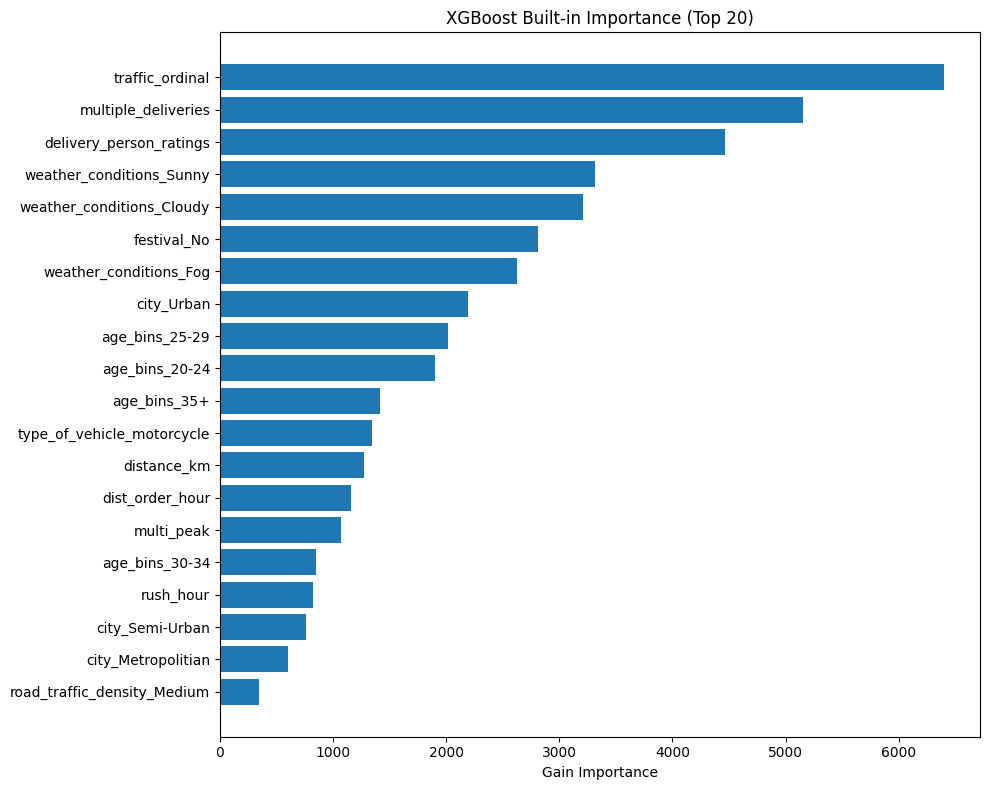

In [29]:
print("\n==============================")
print("  XGBOOST BUILT-IN IMPORTANCE")
print("==============================")

# Extract raw XGBoost model
xgb_model = best_pipe.named_steps["xgb"]
booster = xgb_model.get_booster()

# Importance types: weight, gain, cover, total_gain, total_cover
importance_dict = booster.get_score(importance_type="gain")

# Convert tree node names ("f0", "f1", ...) → actual feature names
booster_feature_names = xgb_model.get_booster().feature_names

mapped_importance = {
    final_feature_names[int(k[1:])]: v
    for k, v in importance_dict.items()
}

xgb_importance_df = (
    pd.DataFrame(
        mapped_importance.items(),
        columns=["feature", "gain_importance"]
    )
    .sort_values("gain_importance", ascending=False)
)

print(xgb_importance_df.head(20))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    xgb_importance_df.head(20)["feature"][::-1],
    xgb_importance_df.head(20)["gain_importance"][::-1],
)
plt.title("XGBoost Built-in Importance (Top 20)")
plt.xlabel("Gain Importance")
plt.tight_layout()
plt.show()



📌 Running Permutation Feature Importance ...

 PERMUTATION FEATURE IMPORTANCE (RAW FEATURES)
                    feature  importance_mean  importance_std
12       weather_conditions         0.294925        0.005148
9   delivery_person_ratings         0.251044        0.003683
1           traffic_ordinal         0.248582        0.004413
8               distance_km         0.127647        0.003519
19                 age_bins         0.120791        0.003108
4       multiple_deliveries         0.100009        0.003860
15          type_of_vehicle         0.041596        0.001731
10          dist_order_hour         0.037861        0.001413
16                 festival         0.029811        0.002126
17                     city         0.014925        0.001143
5          distance_traffic         0.007095        0.000850
3                multi_peak         0.002155        0.000297
13     road_traffic_density         0.002027        0.000183
6             hour_of_order         0.000560        

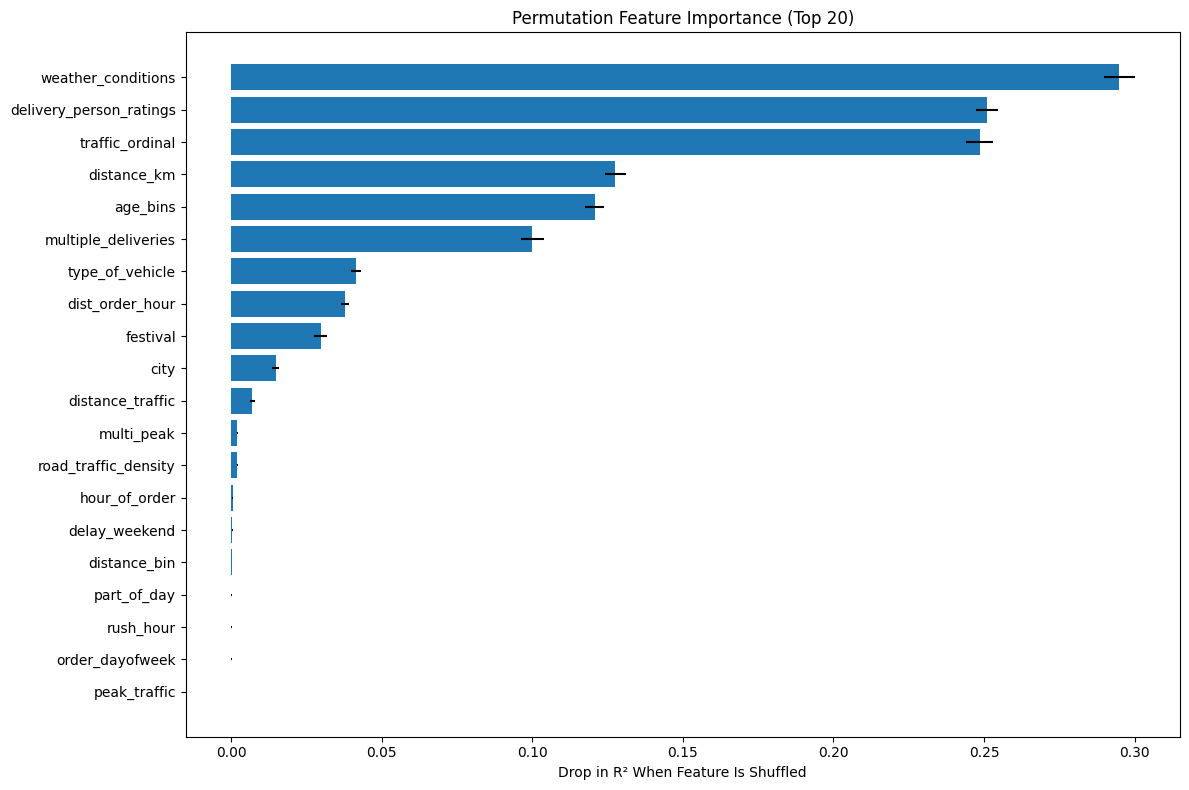

In [33]:
# ============================================================
# 13. PERMUTATION FEATURE IMPORTANCE (CORRECT RAW-FEATURE VERSION)
# ============================================================
from sklearn.inspection import permutation_importance

print("\n📌 Running Permutation Feature Importance ...")

# Compute importance on raw features (pipeline handles preprocessing)
perm = permutation_importance(
    best_pipe,
    X_test,       # <-- raw columns
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)

# Raw feature names (matches perm.importances)
raw_feature_names = list(X_test.columns)

assert len(raw_feature_names) == perm.importances_mean.shape[0]

# Build DataFrame
perm_df = pd.DataFrame({
    "feature": raw_feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print("\n==============================")
print(" PERMUTATION FEATURE IMPORTANCE (RAW FEATURES)")
print("==============================")
print(perm_df)

# --- Plot ---
plt.figure(figsize=(12, 8))
plt.barh(
    perm_df.head(20)["feature"][::-1],
    perm_df.head(20)["importance_mean"][::-1],
    xerr=perm_df.head(20)["importance_std"][::-1]
)
plt.title("Permutation Feature Importance (Top 20)")
plt.xlabel("Drop in R² When Feature Is Shuffled")
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\n🔍 Running Ablation Study...")

# ------------------------------------------------------------
# 1. Get best tuned XGB pipeline (from RandomizedSearchCV)
# ------------------------------------------------------------
best_pipe = random_search.best_estimator_

preprocessor = best_pipe.named_steps["preprocessor"]
xgb_model_only = best_pipe.named_steps["xgb"]

# ------------------------------------------------------------
# 2. Full model evaluation
# ------------------------------------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "R2": r2_score(y_test, pred),
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, pred))
    }

full_scores = evaluate_model(best_pipe, X_train, y_train, X_test, y_test)
full_r2 = full_scores["R2"]

# ------------------------------------------------------------
# 3. Ablation function
# ------------------------------------------------------------
def ablate_feature(feature_name, X_train, X_test):
    X_train_ablate = X_train.drop(columns=[feature_name])
    X_test_ablate = X_test.drop(columns=[feature_name])

    # Create NEW pipeline with adjusted preprocessor
    preprocessor_new = ColumnTransformer([
        ("num", numeric_transformer,
         [f for f in selected_num_features if f != feature_name]),
        ("cat", categorical_transformer,
         [f for f in categorical_features if f != feature_name]),
    ])

    model_new = Pipeline([
        ("preprocessor", preprocessor_new),
        ("xgb", XGBRegressor(
            **xgb_model_only.get_params()
        ))
    ])

    scores = evaluate_model(model_new, X_train_ablate, y_train,
                            X_test_ablate, y_test)

    return scores


# ------------------------------------------------------------
# 4. Perform Ablation Across All Features
# ------------------------------------------------------------
ablation_results = []

all_features = selected_num_features + categorical_features

for feat in all_features:
    print(f"   → Removing feature: {feat}")
    scores = ablate_feature(feat, X_train, X_test)

    ablation_results.append({
        "Feature Removed": feat,
        "R2 After Removal": scores["R2"],
        "Δ R2 Drop": full_r2 - scores["R2"],
        "MAE After Removal": scores["MAE"],
        "RMSE After Removal": scores["RMSE"]
    })

# ------------------------------------------------------------
# 5. Create DataFrame & sort by impact
# ------------------------------------------------------------
ablation_df = pd.DataFrame(ablation_results)
ablation_df = ablation_df.sort_values("Δ R2 Drop", ascending=False)

print("\n==============================")
print("     ABLATION STUDY RESULTS")
print("==============================")
print(ablation_df)

# Optional: save results
ablation_df.to_csv("ablation_study_results.csv", index=False)



🔍 Running Ablation Study...
   → Removing feature: rush_hour
   → Removing feature: traffic_ordinal
   → Removing feature: peak_traffic
   → Removing feature: multi_peak
   → Removing feature: multiple_deliveries
   → Removing feature: distance_traffic
   → Removing feature: hour_of_order
   → Removing feature: delay_weekend
   → Removing feature: distance_km
   → Removing feature: delivery_person_ratings
   → Removing feature: dist_order_hour
   → Removing feature: order_dayofweek
   → Removing feature: weather_conditions
   → Removing feature: road_traffic_density
   → Removing feature: type_of_order
   → Removing feature: type_of_vehicle
   → Removing feature: festival
   → Removing feature: city
   → Removing feature: order_month
   → Removing feature: age_bins
   → Removing feature: part_of_day
   → Removing feature: restaurant_zone
   → Removing feature: customer_zone
   → Removing feature: distance_bin

     ABLATION STUDY RESULTS
            Feature Removed  R2 After Removal  

C:\Users\User\AppData\Local\Temp\ipykernel_20388\2653997069.py:68: UserWarning: Glyph 127755 (\N{VOLCANO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\Miniconda3\envs\myConda\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127755 (\N{VOLCANO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


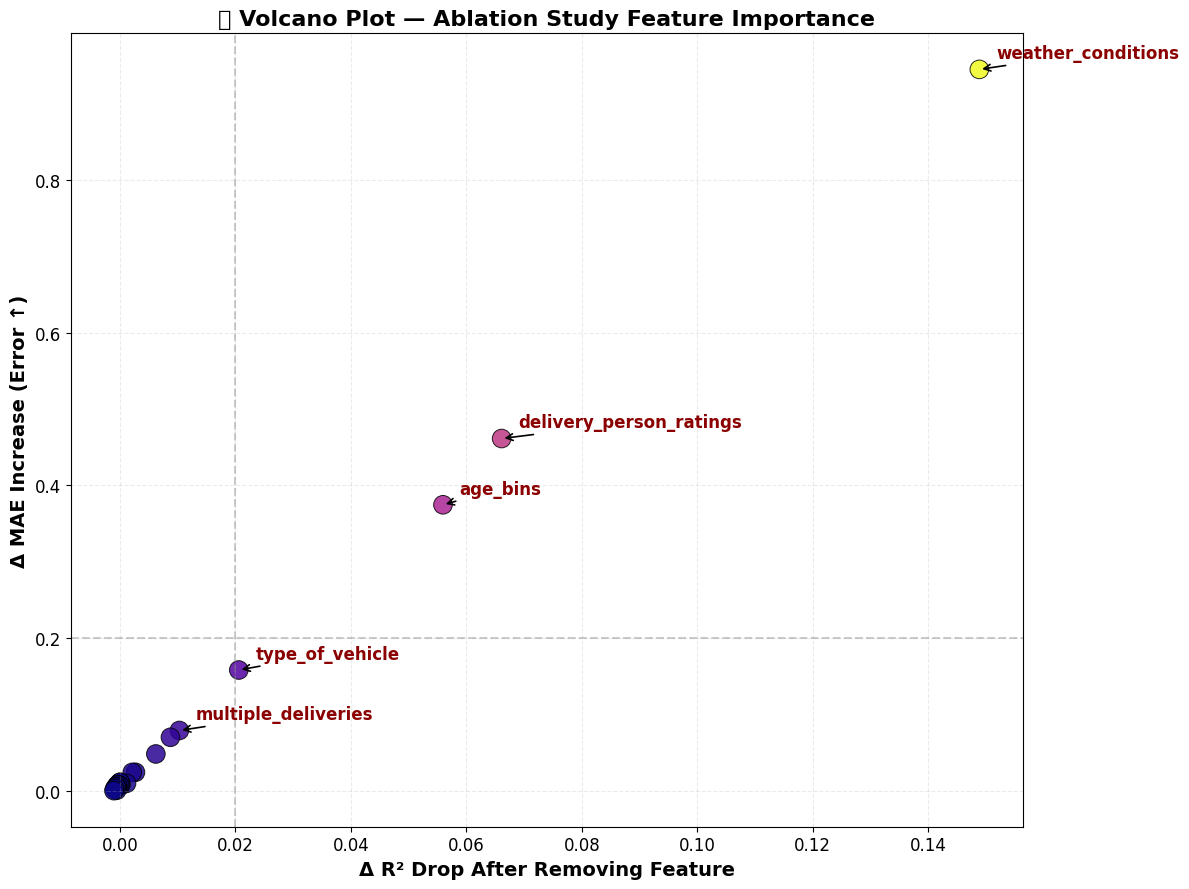

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# PREPARE DATA
# ---------------------------------------------------------
volcano_df = ablation_df.copy()
volcano_df["Δ MAE Increase"] = (
    volcano_df["MAE After Removal"] - ablation_df["MAE After Removal"].min()
)

# Normalize R2 drop for color mapping
norm = (volcano_df["Δ R2 Drop"] - volcano_df["Δ R2 Drop"].min()) / \
       (volcano_df["Δ R2 Drop"].max() - volcano_df["Δ R2 Drop"].min())

# Custom colormap (purple → red)
cmap = plt.cm.plasma

# ---------------------------------------------------------
# CREATE FIGURE (no seaborn required)
# ---------------------------------------------------------
plt.figure(figsize=(12, 9))
plt.grid(alpha=0.25, linestyle="--")

# Scatter points
plt.scatter(
    volcano_df["Δ R2 Drop"],
    volcano_df["Δ MAE Increase"],
    s=180,
    c=cmap(norm),
    alpha=0.85,
    edgecolors="black",
    linewidth=0.7
)

# ---------------------------------------------------------
# Annotate TOP 5 impactful features
# ---------------------------------------------------------
top_features = volcano_df.sort_values("Δ R2 Drop", ascending=False).head(5)

for _, row in top_features.iterrows():
    plt.annotate(
        row["Feature Removed"],
        xy=(row["Δ R2 Drop"], row["Δ MAE Increase"]),
        xytext=(12, 8),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold",
        color="darkred",
        arrowprops=dict(arrowstyle="->", lw=1.2, color="black")
    )

# ---------------------------------------------------------
# Optional reference lines
# ---------------------------------------------------------
plt.axvline(0.02, color="gray", linestyle="--", alpha=0.4)
plt.axhline(0.2, color="gray", linestyle="--", alpha=0.4)

# ---------------------------------------------------------
# LABELS & DESIGN
# ---------------------------------------------------------
plt.xlabel("Δ R² Drop After Removing Feature", fontsize=14, fontweight="bold")
plt.ylabel("Δ MAE Increase (Error ↑)", fontsize=14, fontweight="bold")
plt.title("🌋 Volcano Plot — Ablation Study Feature Importance", fontsize=16, fontweight="bold")

plt.tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.show()
